In [ ]:
# if true, will mount your google drive and save the trained model in 'crafter_models' directory
save_to_drive = True
# colab can handle ~45000-50000
dataset_size = 45000

epochs = 50

# push this higher to be faster, but works well with 32
batch_size=32

In [ ]:
# install dependencies
! python -m pip install crafter wget datasets

In [ ]:
# download code and set env variable
! git clone https://github.com/Oliver-Tautz/Critic-VAE/ criticVae
import sys
sys.path.append("/content/criticVae")

Cloning into 'criticVae'...
remote: Enumerating objects: 937, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 937 (delta 137), reused 169 (delta 79), pack-reused 696
Receiving objects: 100% (937/937), 332.61 MiB | 26.11 MiB/s, done.
Resolving deltas: 100% (304/304), done.


In [ ]:
from crafter_extension_dataset import CrafterCriticDataset
from crafter_extension_utils import collect_data, choose
from crafter_extension_model import Critic

In [ ]:
import multiprocessing
ncpu = multiprocessing.cpu_count()
import torch
import os
torch.set_num_threads(ncpu)
torch.set_num_interop_threads(ncpu)


replay_dir = '/content/dataset'
os.makedirs(replay_dir,exist_ok=True)

In [ ]:
X,Y,_ = collect_data(replay_dir,download=True)

/content/dataset
downloaded  /content/dataset/dataset.zip

Unzipping ...


loading episodes ...: 100%|██████████| 100/100 [00:02<00:00, 37.09it/s]


In [ ]:
X = torch.tensor(X).permute(0,3,1,2) / 255

In [ ]:
critic = Critic()
history = critic.fit_on_crafter(X,Y,batch_size = 32,epochs=50,dataset_size=45000)

train_epochs:   0%|          | 0/50 [00:00<?, ?it/s]

train_epochs: 100%|██████████| 50/50 [11:30<00:00, 13.81s/it]


In [ ]:
history['train_acc'] = [a['accuracy'] for a in history['train_acc']]
history['val_acc'] = [a['accuracy'] for a in history['val_acc']]

In [ ]:
import pandas as pd

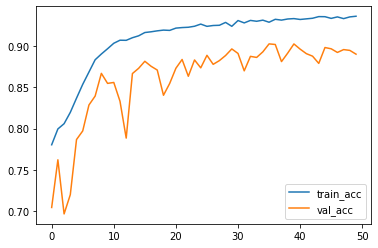

In [ ]:
pd.DataFrame(history)[['train_acc','val_acc']].plot()

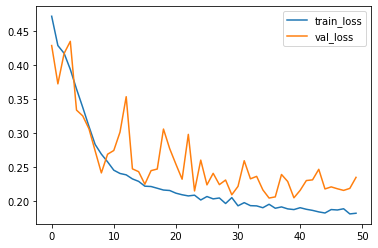

In [ ]:
pd.DataFrame(history)[['train_loss','val_loss']].plot()

In [ ]:
from os import makedirs
from pathlib import Path
os.makedirs(f"critic-batch_size={32}-dataset_size={45000}-epochs={50}",exist_ok=True)

In [ ]:
torch.save(critic.state_dict(),Path(f"critic-batch_size={32}-dataset_size={45000}-epochs={50}") / 'critic.pt')
if save_to_drive:
  from google.colab import drive
  !mkdir drive
  drive.mount('/content/drive')
  makedirs(f"/content/drive/MyDrive/crafter_models/critic-batch_size={32}-dataset_size={45000}-epochs={50}",exist_ok=True)
  torch.save(critic.state_dict(),Path(f"/content/drive/MyDrive/crafter_models/critic-batch_size={32}-dataset_size={45000}-epochs={50}") / 'critic.pt')

Mounted at /content/drive


In [ ]:
# test model load
import torch
critic = Critic()
critic.load_state_dict(torch.load(Path(f"critic-batch_size={32}-dataset_size={45000}-epochs={50}") / 'critic.pt'))

<All keys matched successfully>

In [ ]:
# prepare positive and negative examples
positive = X[Y==1]
negative = X[Y==0]
logits_positive = (critic(positive))
logits_negative = critic(choose(negative,2000))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd92c58fcd0>]],
      dtype=object)

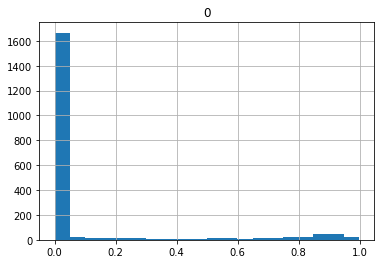

In [ ]:
# outputs for negative samples
pd.DataFrame((torch.nn.Sigmoid()(logits_negative)).detach().numpy()).hist(bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd92ba23ad0>]],
      dtype=object)

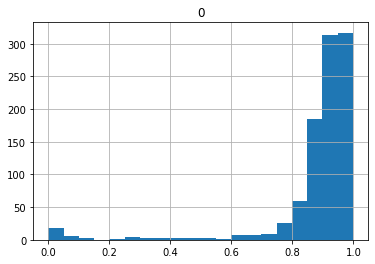

In [ ]:
# outputs for positive samples
pd.DataFrame((torch.nn.Sigmoid()(logits_positive)).detach().numpy()).hist(bins=20)